# Answering Business Questions using SQL

In this project, we'll use Pandas and SQL to perform data analysis and create data visualizations.

We will address the following questions:
  1. Selecting albums to purchase.
  2. Analyzing employees' sales performance
  3. Analyzing sales by country
  4. Analyzing purchased and not-purchased tracks


# Connect to chinook database

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

# Import libraries

In [2]:
import sqlite3 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime

# Create helper function

In [3]:
def convert_df(q):
    #Take a query and return a pandas dataframe
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

# Overview of the Data

In [4]:
%%sql
SELECT 
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


# Selecting albums to purchase

In [5]:
genre_query = '''
SELECT
    g.name genre,
    SUM(il.quantity) num_track_sold,
    ROUND(CAST(SUM(il.quantity) AS FLOAT)/(SELECT
                         SUM(il.quantity) total_track_sold
                         FROM genre g
                         INNER JOIN track t ON g.genre_id = t.genre_id
                         INNER JOIN invoice_line il ON il.track_id = t.track_id
                         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                         WHERE i.billing_country = 'USA') * 100, 4) percentage_track_sold
FROM genre g
INNER JOIN track t ON g.genre_id = t.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
WHERE i.billing_country = 'USA'
GROUP BY g.name
ORDER BY 2 DESC
LIMIT 10
'''

genre_df = convert_df(genre_query)
genre_df

,genre,num_track_sold,percentage_track_sold
0,Rock,561,53.3777
1,Alternative & Punk,130,12.3692
2,Metal,124,11.7983
3,R&B/Soul,53,5.0428
4,Blues,36,3.4253
5,Alternative,35,3.3302
6,Latin,22,2.0932
7,Pop,22,2.0932
8,Hip Hop/Rap,20,1.9029
9,Jazz,14,1.3321


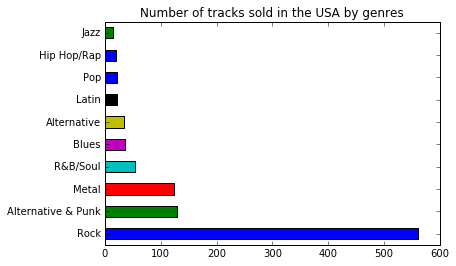

In [6]:
genre_df.plot(kind = 'barh', x = 'genre', y = 'num_track_sold', title = 'Number of tracks sold in the USA by genres', legend = False)
plt.ylabel('')

Based on the sales of tracks across different genres in the US, rock accounts for over 53% of sales is the most favorite genre. Alternative & Punk and Metal are the second and third most favorite genre in the US, with around 12.4% and 11.8% of sales, respectively.

# Analyzing Employee Sales Performance

In [7]:
sales_query = '''
SELECT
    e.first_name || " " || e.last_name employee,
    ROUND(SUM(i.total), 2) sales_total,
    e.hire_date hire_date
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE title = 'Sales Support Agent'
GROUP BY 1
'''
sales_df = convert_df(sales_query)
sales_df

,employee,sales_total,hire_date
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


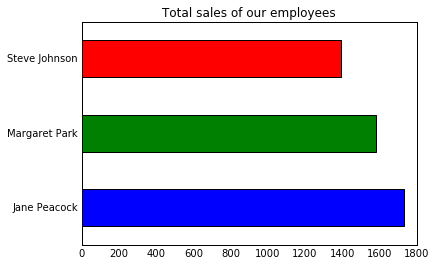

In [8]:
sales_df.plot(kind = 'barh', x = 'employee', y = 'sales_total', title = 'Total sales of our employees', legend = False)
plt.ylabel('')
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

Based on the graph and the table above, Jane had the highest total sales while Steve's total sales were the lowest. However, we cannot conclude that Jane's performance was better than Margaret or Steve because they started working on different dates.

# Analyzing Sales by Country

In [9]:
country_query = '''

WITH 
table_1 as (
    SELECT 
        c.country country,
        COUNT(DISTINCT c.customer_id) num_customer,
        SUM(i.total) total_value_sales,
        CAST(SUM(i.total) AS FLOAT)/COUNT(DISTINCT c.customer_id) sales_per_customer,
        CAST(SUM(i.total) AS FLOAT)/COUNT(i.invoice_id) avg_order_value,
        COUNT(i.invoice_id) num_order,
        CASE
            WHEN COUNT(DISTINCT c.customer_id) = 1 THEN 'Others'
            ELSE c.country
        END AS country_name
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY c.country),
table_2 as (
    SELECT *
    FROM table_1
    WHERE country_name = 'Others'),
table_3 as (
    SELECT
        country_name country,
        SUM(num_customer) num_customer,
        SUM(total_value_sales) total_value_sales,
        SUM(total_value_sales)/SUM(num_customer) sales_per_customer,
        SUM(total_value_sales)/(SELECT SUM(num_order) FROM table_1 WHERE country_name = 'Others') avg_order_value
    FROM table_2
    GROUP BY 1),
table_4 as (
    SELECT 
        country,
        num_customer,
        total_value_sales,
        sales_per_customer,
        avg_order_value
    FROM table_1
    WHERE num_customer <> 1),
table_5 as (
    SELECT * FROM table_4
    UNION
    SELECT * FROM table_3)

SELECT 
    country, 
    num_customer,
    ROUND(total_value_sales, 2) total_value_sales,
    ROUND(sales_per_customer, 2) sales_per_customer,
    ROUND(avg_order_value, 2) avg_order_value
FROM (SELECT 
        *,
        CASE
            WHEN country = 'Others' THEN 1
            ELSE 0
        END AS sort
    FROM table_5)
ORDER BY sort, total_value_sales DESC
'''
country_df = convert_df(country_query)
country_wo_others = country_df.iloc[0:-1,:]
country_df

,country,num_customer,total_value_sales,sales_per_customer,avg_order_value
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,Czech Republic,2,273.24,136.62,9.11
6,United Kingdom,3,245.52,81.84,8.77
7,Portugal,2,185.13,92.57,6.38
8,India,2,183.15,91.57,8.72
9,Others,15,1094.94,73.00,7.45


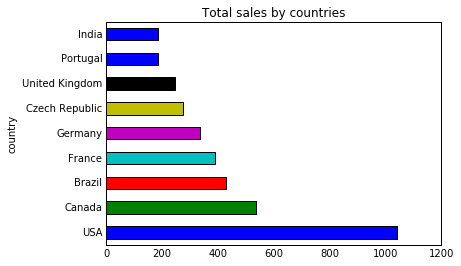

In [10]:
country_wo_others.plot(kind = 'barh', x = 'country', y = 'total_value_sales', title = 'Total sales by countries', legend = False)
plt.ylabel = ''
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

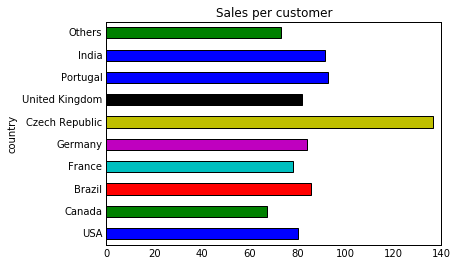

In [11]:
country_df.plot(kind = 'barh', x = 'country', y = 'sales_per_customer', title = 'Sales per customer', legend = False)
plt.ylabel = ''
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

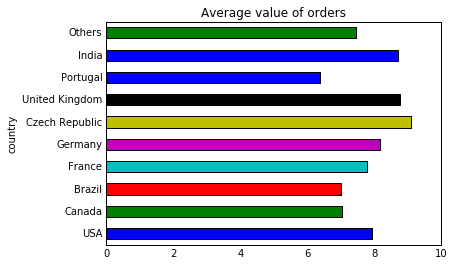

In [12]:
country_df.plot(kind = 'barh', x = 'country', y = 'avg_order_value', title = 'Average value of orders', legend = False)
plt.ylabel = ''
plt.tick_params(bottom="off", top="off", left="off", right="off")
plt.show()

Based on the graph of Total sales by country, the US has the highest total sales. However, the sales per customer and Average value of orders graphs show that the Czech Republic and India can be two potential countries.

# Purchased vs Not purchased Tracks

In [23]:
status_query = '''
WITH track_status as
(SELECT
    t.track_id track_id,
    il.invoice_line_id invoice_line_id,
    CASE
        WHEN il.invoice_line_id IS NULL THEN 'Not purchased'
        ELSE 'Purchased'
    END AS status
FROM track t
LEFT JOIN invoice_line il ON il.track_id = t.track_id)

SELECT
    status,
    COUNT(DISTINCT track_id) num_track,
    (CAST(COUNT(DISTINCT track_id) AS FLOAT) / (1697 + 1806)) percentage 
FROM track_status
GROUP BY status
'''
status_df = convert_df(status_query)
status_df

,status,num_track,percentage
0,Not purchased,1697,0.484442
1,Purchased,1806,0.515558


([<matplotlib.patches.Wedge at 0x7efc9d0cf400>,
  <matplotlib.text.Text at 0x7efc9d05cf98>])

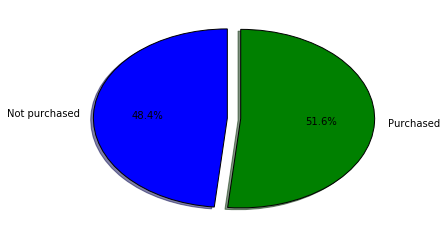

In [31]:
labels = status_df['status']
sizes = status_df['num_track']

fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, startangle = 90, autopct = '%1.1f%%', shadow = True, explode = (0, 0.1))

The percentage of purchased tracks is slightly higher than that of not-purchased tracks based on the graph. It suggests that we explore not-purchased tracks to see whether we should keep buying these or spend money on buying more purchased tracks.